In [34]:
import gdown

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import os
import cv2
import tensorflow as tf
from typing import List
from matplotlib import pyplot as plt
import imageio
import numpy as np

In [37]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [38]:
model = tf.keras.models.load_model("/content/drive/MyDrive/lipnet01.h5", custom_objects={'CTCLoss': CTCLoss})

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, None, 100, 200,    3584      
                             128)                                
                                                                 
 activation (Activation)     (None, None, 100, 200,    0         
                             128)                                
                                                                 
 max_pooling3d (MaxPooling3  (None, None, 50, 100, 1   0         
 D)                          28)                                 
                                                                 
 conv3d_1 (Conv3D)           (None, None, 50, 100, 2   884992    
                             56)                                 
                                                                 
 activation_1 (Activation)   (None, None, 50, 100, 2   0

In [40]:
#'''ffmpeg -i C:\Users\Admin\Downloads\lipnet\test.mpg -vf "scale=360:288" -c:v mpeg2video -q:v 2 -an C:\Users\Admin\Downloads\lipnet\test01.mpg'''

In [41]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))

    # Ensure frames and mean are of the same data type (float32)
    frames = tf.cast(frames, tf.float32)
    mean = tf.cast(mean, tf.float32)

    # Perform the subtraction and division
    frames = (frames - mean) / std
    return frames

In [42]:
tf.convert_to_tensor('/content/drive/MyDrive/test.mpg')

<tf.Tensor: shape=(), dtype=string, numpy=b'/content/drive/MyDrive/test.mpg'>

In [59]:
cap = cv2.VideoCapture('/content/drive/MyDrive/test05Yan.mp4')
frames = []
for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    ret, frame = cap.read()
    frame = tf.image.rgb_to_grayscale(frame)
    frames.append(frame[375:475,600:800])
cap.release()

frames = tf.convert_to_tensor(frames)
mean = tf.math.reduce_mean(frames)
std = tf.math.reduce_std(tf.cast(frames, tf.float32))

# Ensure frames and mean are of the same data type (float32)
frames = tf.cast(frames, tf.float32)
mean = tf.cast(mean, tf.float32)

# Perform the subtraction and division
result = tf.cast((frames - mean), tf.float32) / std



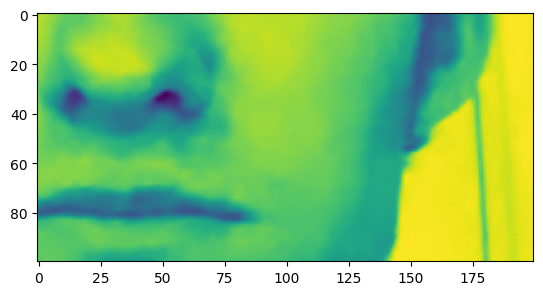

In [63]:
result_np = result.numpy()

# Display the frame using Matplotlib
plt.imshow(result_np[651])
plt.show()

In [64]:
result_np = np.expand_dims(result_np, axis=0)

In [65]:
model.input_shape

(None, None, 100, 200, 1)

In [66]:
result_np.shape

(1, 652, 100, 200, 1)

In [68]:
pred = model.predict(result_np)

1/1 [==============================] - 182s 182s/step


In [69]:
pred

array([[[6.1852159e-04, 1.6954970e-03, 3.8923049e-01, ...,
         6.5209719e-08, 1.9130388e-02, 9.0498319e-03],
        [9.2952840e-05, 3.4431310e-03, 1.7569203e-02, ...,
         1.5024906e-09, 2.7132852e-03, 9.6248267e-03],
        [4.2732497e-04, 2.6755827e-02, 9.6635008e-03, ...,
         1.9458020e-09, 4.1237768e-02, 2.7396157e-02],
        ...,
        [9.6248841e-01, 8.4885556e-08, 3.7561126e-08, ...,
         2.1475606e-09, 1.0800930e-07, 3.7462790e-02],
        [2.2252589e-02, 1.9324874e-07, 3.1690224e-08, ...,
         1.0453890e-09, 2.4143958e-07, 9.7765517e-01],
        [9.6623003e-01, 6.5095497e-07, 2.2413589e-07, ...,
         7.5655635e-08, 4.4450451e-07, 3.3646483e-02]]], dtype=float32)

In [70]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [71]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

In [77]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(pred[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'beeeeeee     eeee   aaaan'>